https://www.kaggle.com/paulorzp/gmean-of-light-gbm-models-lb-0-95x

In [35]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import featuretools as ft
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

%matplotlib inline
RSEED = 50

In [36]:
all_files = ['./data/sub_feat457_modelselect.csv',
            './data/sub_feat476_rmv91.csv',
            './data/sub_xgb_feat457_lr001.csv']

In [37]:
outs = [pd.read_csv(all_files[f], index_col=0) for f in range(0,len(all_files))]
all_sub = pd.concat(outs, axis=1)
cols = list(map(lambda x: "sub" + str(x), range(len(all_sub.columns))))
all_sub.columns = cols
all_sub.reset_index(inplace=True)

In [38]:
all_sub.head()

,TransactionID,sub0,sub1,sub2
0,3663549,0.001578,0.001143,0.002200
1,3663550,0.000631,0.000615,0.001713
2,3663551,0.001217,0.000959,0.003700
3,3663552,0.001046,0.001142,0.002324
4,3663553,0.000626,0.000441,0.001152


In [39]:
# calculate correlation of submissions
corr = all_sub.iloc[:,1:].corr()

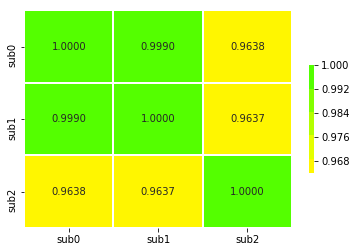

In [40]:
sns.heatmap(corr,cmap='prism',center=0, linewidths=1,
            annot=True,fmt='.4f', cbar_kws={"shrink":.5})

# Weighted GMEAN by inverse correlation

In [41]:
corr_rank = np.tril(all_sub.iloc[:,1:].corr().values,0)+np.triu(np.ones(corr.shape),1)
corr_rank

array([[1.        , 1.        , 1.        ],
       [0.99902149, 1.        , 1.        ],
       [0.96379093, 0.96374118, 1.        ]])

In [42]:
# calculate how many times of blend is needed
blend_times = (corr_rank>0).sum() - (corr_rank>0.99).sum()
blend_times

2

In [43]:
m_gmean, weight_sum = 0, 0

In [44]:
# https://en.wikipedia.org/wiki/Weighted_geometric_mean
for i in range(blend_times):
    min_corr_indexs = np.unravel_index(corr_rank.argmin(), corr_rank.shape)
    print('%s round with current minimual index%s'%(i,min_corr_indexs))
    # weight decay with higher correlations
    weight = (blend_times-i)/blend_times
    m_gmean += weight*(np.log(all_sub.iloc[:,min_corr_indexs[0]+1])+np.log(all_sub.iloc[:,min_corr_indexs[1]+1]))/2
    print(m_gmean.head())
    weight_sum += weight
    print('current weight:%s, total weight:%s'%(weight,weight_sum))
    corr_rank[min_corr_indexs] = 1
    print(corr_rank)

0 round with current minimual index(2, 1)
0   -6.446795
1   -6.881301
2   -6.274738
3   -6.419609
4   -7.246587
dtype: float64
current weight:1.0, total weight:1.0
[[1.         1.         1.        ]
 [0.99902149 1.         1.        ]
 [0.96379093 1.         1.        ]]
1 round with current minimual index(2, 0)
0    -9.589538
1   -10.315535
2    -9.352433
3    -9.651312
4   -10.782282
dtype: float64
current weight:0.5, total weight:1.5
[[1.         1.         1.        ]
 [0.99902149 1.         1.        ]
 [1.         1.         1.        ]]


In [45]:
m_gmean = np.exp(m_gmean/weight_sum)
m_gmean.head()

0    0.001673
1    0.001031
2    0.001960
3    0.001606
4    0.000755
dtype: float64

In [46]:
m_gmean = (m_gmean-m_gmean.min())/(m_gmean.max()-m_gmean.min())
m_gmean.head()

0    0.001574
1    0.000931
2    0.001861
3    0.001507
4    0.000655
dtype: float64

In [47]:
all_sub['isFraud'] = m_gmean
all_sub.tail()

,TransactionID,sub0,sub1,sub2,isFraud
506686,4170235,0.005848,0.004480,0.007397,0.005924
506687,4170236,0.002687,0.002441,0.002580,0.002452
506688,4170237,0.002786,0.002777,0.001923,0.002214
506689,4170238,0.002308,0.002219,0.003580,0.002739
506690,4170239,0.003451,0.004219,0.003075,0.003387


In [48]:
all_sub[['TransactionID','isFraud']].to_csv('./data/sub_3stack_gmean.csv',index=False)